In [5]:
import os
import json
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

from helper_functions.schedules import Full_Horizon_Schedule
from schedulers.bigraph_matching import solve_bipartite_matching
from simulation_environment.simulator_2D import Simulation
from training_helpers import create_task_features, create_robot_features, get_expert_reward
from transformer_models import TransformerScheduler
from visualizations.solution_visualization import plot_gantt_chart, plot_robot_trajectories

### Dataset of exact solutions of Full_Horizon_Schedules

In [6]:
def load_dataset(problem_dir, solution_dir):
    problems = []
    solutions = []
    
    # Load all problem instances
    for file_name in sorted(os.listdir(problem_dir)):
        with open(os.path.join(problem_dir, file_name), "r") as f:
            problems.append(json.load(f))
    
    # Load all solution files
    for file_name in sorted(os.listdir(solution_dir)):
        with open(os.path.join(solution_dir, file_name), "r") as f:
            solutions.append(json.load(f))
    
    solutions = [Full_Horizon_Schedule.from_dict(solution) for solution in solutions]
    
    return problems, solutions

In [7]:
# Define paths
problem_dir = "/home/jakob/thesis/datasets/simple_dataset_1000/problem_instances"
solution_dir = "/home/jakob/thesis/datasets/simple_dataset_1000/solutions"

# Load dataset
problems, solutions = load_dataset(problem_dir, solution_dir)

In [8]:
def find_decision_points(solution):
    end_time_index = 2
    end_times_of_tasks = np.array([task[end_time_index] for tasks in solution.robot_schedules.values() for task in tasks])
    decision_points = np.unique(end_times_of_tasks)

    # Also beginning of mission is decsision point --> append 0
    return np.ceil(np.append([0],decision_points))

IntSlider(value=500, continuous_update=False, description='Solution:', max=999)

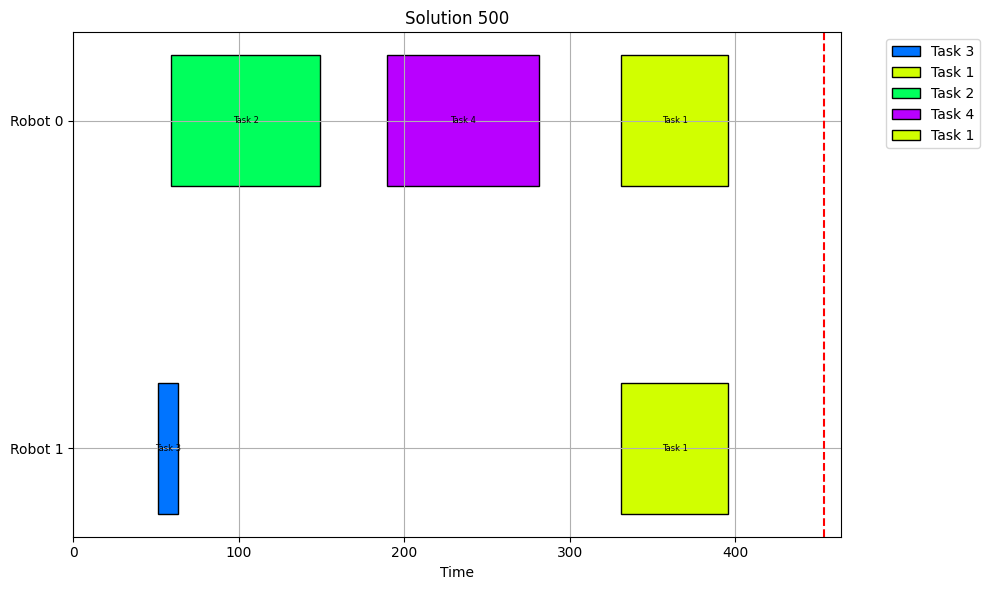

Schedule:
  Number of tasks: 4
  Number of robots: 2
  Makespan/Arrival at end location: 454.00
  Robot Tasks:
    Robot 0:
      Task 2: 59.10 -> 149.10
      Task 4: 189.50 -> 281.50
      Task 1: 331.00 -> 396.00
    Robot 1:
      Task 3: 51.20 -> 63.20
      Task 1: 331.00 -> 396.00

[  0.  64. 150. 282. 396.]


In [9]:
def update_plot(change):
    """Update the Gantt chart when the slider value changes."""
    index = slider.value  # Get the current slider value
    solution = solutions[index]
    clear_output(wait=True)  # Clear previous output
    display(slider)  # Re-display the slider
    plot_gantt_chart(f"Solution {index}", solution)  # Plot the updated Gantt chart
    print(f"{solutions[index]}")
    print(find_decision_points(solutions[index]))

# Create the slider
slider = widgets.IntSlider(
    value=0,  # Default starting index
    min=0,    # Minimum index
    max=len(solutions) - 1,  # Maximum index based on solutions size
    step=1,   # Step size for the slider
    description='Solution:',
    continuous_update=False, # Update only when the slider is released
    )

# Attach the update function to the slider's change event
slider.observe(update_plot, names='value')

update_plot(None)  # Display the initial plot


### Extract expert rewards at decision points

In [10]:
index = 500
solution = solutions[index]
problem = problems[index]
decision_points = find_decision_points(solution)

sim = Simulation(problem, precedence_constraints=[])
sim.tasks = sim.tasks[1:-1] # Exclude start and end task
for decision_time in decision_points:
    E, X = get_expert_reward(solution.robot_schedules, decision_time=decision_time)
    
    print(f"At decision time {decision_time}:")
    solve_bipartite_matching(E, sim)
    print("\n\n")


At decision time 0.0:
solver status: Optimal
bipartite matching done with makespan 0.7533034312455678 and solution {(0, 0): 0, (0, 1): 1, (0, 2): 0, (0, 3): 0, (1, 0): 0, (1, 1): 0, (1, 2): 1, (1, 3): 0}
robot assignments: {0: 1, 1: 2}



At decision time 64.0:
solver status: Optimal
bipartite matching done with makespan 0.11237114987975103 and solution {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 1, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0}
robot assignments: {0: 3}



At decision time 150.0:
solver status: Optimal
bipartite matching done with makespan 0.2667031158899642 and solution {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 1, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0}
robot assignments: {0: 3}



At decision time 282.0:
solver status: Optimal
bipartite matching done with makespan 0.635978127638287 and solution {(0, 0): 1, (0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 0): 1, (1, 1): 0, (1, 2): 0, (1, 3): 0}
robot assignments: {0: 0, 1: 0}



At decision time 396.0:
solver status: Optimal
bipa

### Extract task and robot features for decision point

In [15]:
task_features = create_task_features(problem, solution.robot_schedules, 350)

/home/jakob/thesis/method_explorations/LVWS/training_helpers.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(task_features, dtype=torch.float32).unsqueeze(0)


In [16]:
robot_features = create_robot_features(problem, solution.robot_schedules, 350)

In [37]:
# Example input
batch_size = 1 

scheduling_network = TransformerScheduler(robot_input_dimensions=3, task_input_dimension=5, embed_dim=32, ff_dim=64, num_layers=2)

In [ ]:
reward_matrix = scheduling_network(robot_features, task_features)
reward_matrix